In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
import time
import matplotlib.pyplot as plt

# import utils from directory above     
# Get the parent directory of the 'notebooks' folder (which is the root project directory)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now, you can import the 'yahoo' module from the 'data' folder
from data import yahoo
from strategy.simple_momentum import simple_momentum_1
from backtest.backtest import calculate_profit
from utils.plot import plot_strategy


### VARIABLES

In [2]:
##  data slice to search for
START_DATE = '01/01/2024'  
END_DATE = ''
TICKER = 'VIXY'  ## ticker used [compatiable to data source used]
HISTORIC_PERIOD = ''  ## years to search over
FEATURE = 'Close'  ## feature to fit to
NORM = 1 ##  norm to use
INTERVAL = 60*24  ##  interval in mins

___

### VIEW DATA

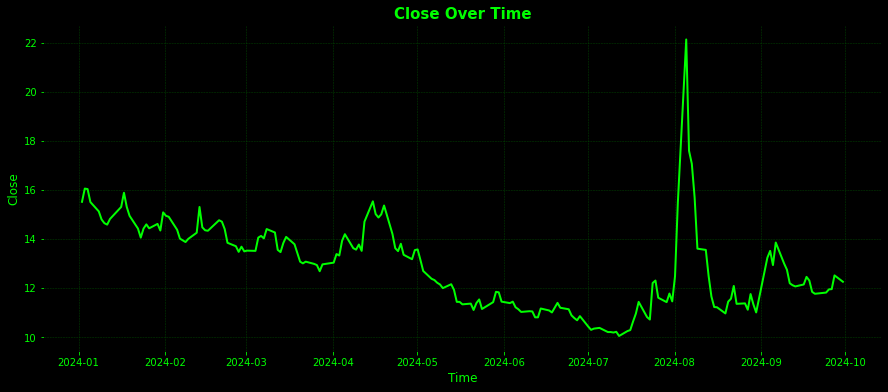

In [3]:
# Import data
data = yahoo.Yahoo()

if HISTORIC_PERIOD != '':
    history_start = (time.now() - timedelta(days=(HISTORIC_PERIOD*365))).strftime('%d/%m/%Y')
else: 
    history_start = (datetime.strptime(START_DATE, '%d/%m/%Y')).strftime('%d/%m/%Y')

# Call data
df = data.get_history(ticker=TICKER, data_interval=INTERVAL, start_date=history_start, end_date=datetime.utcnow().strftime('%d/%m/%Y'))

# Slice df
df.index = pd.to_datetime(df.index,utc=True)
df = df[df.index > history_start]
df = df[~df.index.duplicated(keep='first')]
sample_df = df[[FEATURE]].copy()
sample_df.columns = sample_df.columns.str.lower()

# Plot data
# Create a figure and an axis using subplots
fig, ax = plt.subplots(figsize=(15, 6))

# Set the retro style background color (black) and line color (green)
fig.set_facecolor('black')
ax.set_facecolor('black')  # Set axis background color to black
ax.plot(df[FEATURE], color='#00FF00', linewidth=2)  # Retro terminal green

# Set title, labels, and grid
ax.set_title(f"{FEATURE.capitalize()} Over Time", fontsize=15, color='#00FF00', fontweight='bold')
ax.set_xlabel("Time", fontsize=12, color='#00FF00')
ax.set_ylabel(FEATURE.capitalize(), fontsize=12, color='#00FF00')

# Change x and y ticks color to green
ax.tick_params(axis='x', colors='#00FF00')
ax.tick_params(axis='y', colors='#00FF00')

# Add grid with green lines
ax.grid(color='#004400', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

___

### STRATEGIES

#### *1. Simple Momentum*

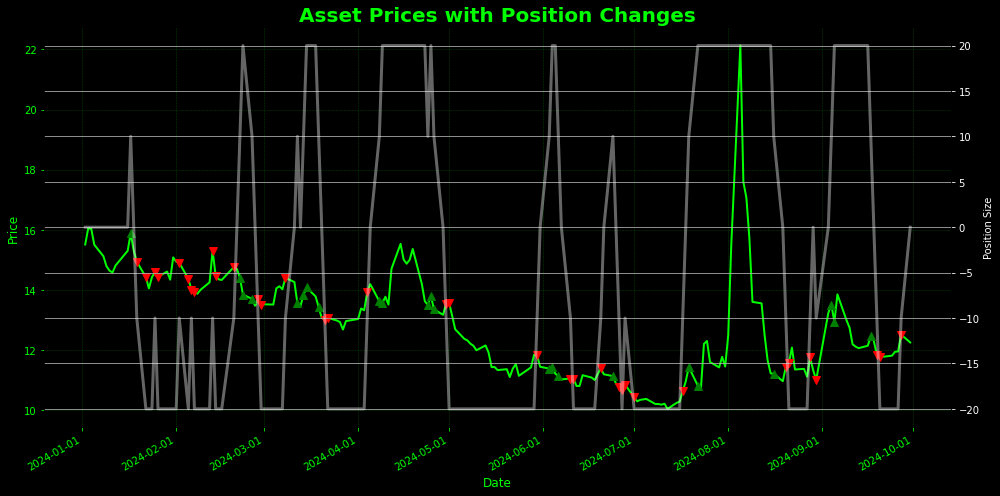

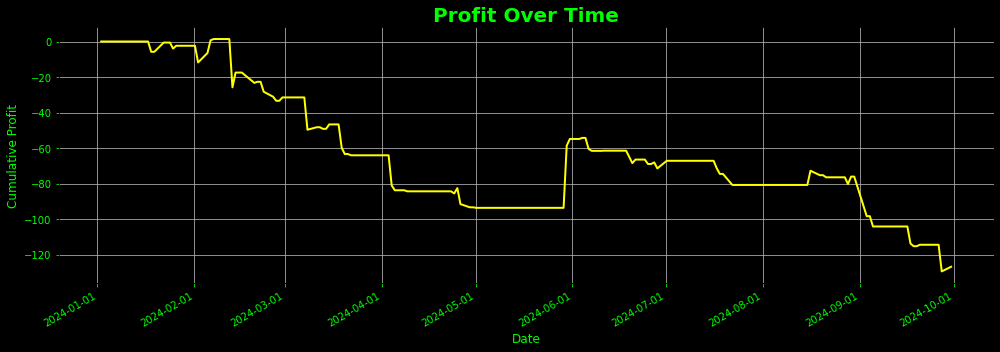

In [4]:
# Get signals and profits from strategy module
sample_df['position_size'] = simple_momentum_1(df, 100, 10)
profit_df = calculate_profit(sample_df)

# Plot
plot_strategy(sample_df, profit_df)

In [35]:
cap = 3

# Get trades
df['R'] = df['Close'].pct_change()
R = df['R']
signal = np.sign(R.rolling(10, min_periods=10).mean())
final_positions_usd = 10/10 * signal
final_positions_usd = final_positions_usd.fillna(0)

# Pre allocate
total_pos = 0
pos = np.zeros(len(final_positions_usd))

for i, trade in enumerate(final_positions_usd): 
    if abs(total_pos + trade) <= cap: 
        total_pos += trade
    else: 
        None
    pos[i] = total_pos

final_positions_usd.loc[:] = pos

___

### PLOT

IndexError: list index out of range

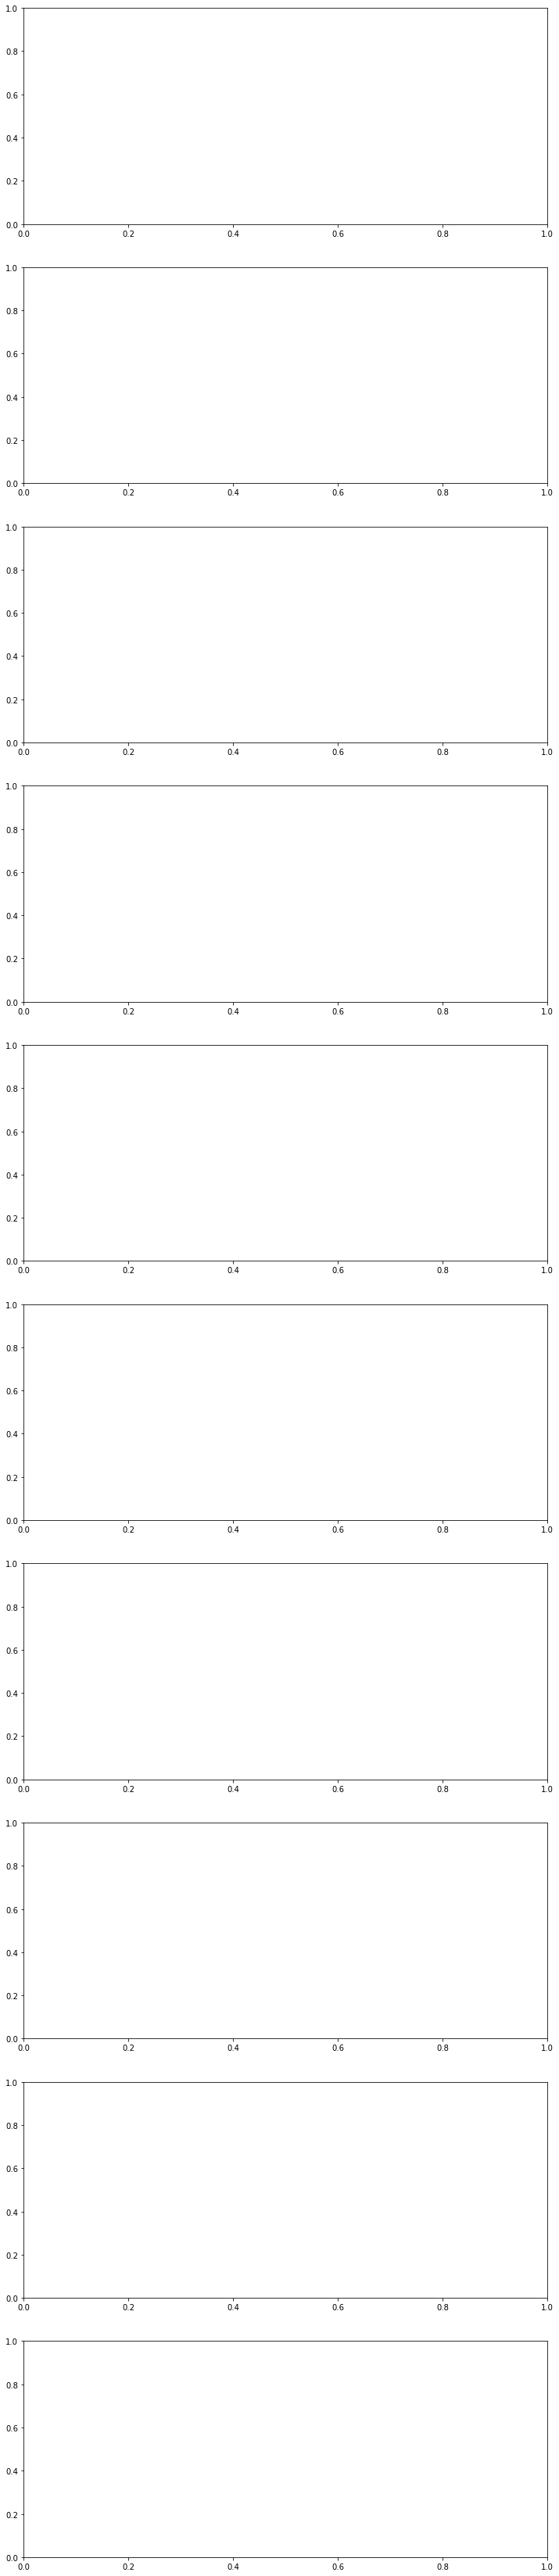

In [15]:
# plotting

#------------------------------------#
SHOW = 10# number of plots to show
#------------------------------------#

from matplotlib import rc
rc('text', usetex=False)

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

fig, axs = plt.subplots(SHOW, 1, figsize=(12, 6*SHOW))

for i in range(SHOW):
    
    result = df.loc[residuals[i][0]::].head(window) / df.loc[residuals[i][0]]
    reference = sample_df.copy() / sample_df.iloc[0]
    
    resi = residuals[i][1]
    date = residuals[i][0]
    
    ##  found data
    ax1 = axs[i]
    ax1.plot(result, label='found window', linewidth=1.5, color='green')
    ax1.set_xlabel('Date [past]')
    ax1.set_ylabel('Rel. Change')

    ax1.set_xticks(result.index)
    ax1.tick_params(direction="in", length=4, width=0.6)
    ax1.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)
    
    ##  reference data
    ax2 = ax1.twiny()
    ax2.plot(reference, label='reference window', linewidth=1.5, color='blue')
    
    ax2.set_xlabel('Date [ref]')
    
    ax2.set_xticks(reference.index)
    ax2.set_xticklabels(reference.index)
    ax2.tick_params(direction="in", length=4, width=0.6)
    ax2.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)

    ##  legends
    leg = ax1.legend(loc='upper center', bbox_to_anchor=(.8, 0.25),
              fancybox=False, shadow=False, ncol=3, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    leg = ax2.legend(loc='upper center', bbox_to_anchor=(.8, 0.35),
              fancybox=False, shadow=False, ncol=3, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    title = ax1.set_title('No. '+str(i+1)+" Historic Match ["+str(result.index[0])[0:10]+' - '+str(result.index[-1])[0:10]+']')

fig.tight_layout()
plt.show()

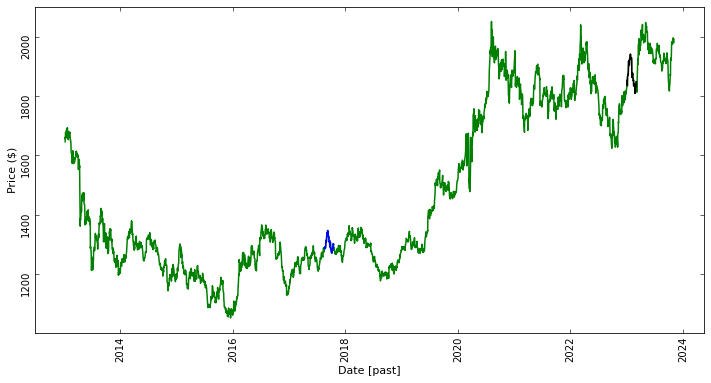

In [243]:
# plotting with bigger picture

#------------------------------------#
OPTION = 1  # which solution to view
#------------------------------------#

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

##  all data
axs.plot(df, label='All Data', linewidth=1.5, color='green')
axs.set_xlabel('Date [past]')
axs.set_ylabel('Price ($)')

##  highlight interest areas
axs.plot(sample_df, label='All Data', linewidth=1.5, color='black')
axs.plot(df.loc[residuals[OPTION-1][0]::].head(window), linewidth=1.5, color='blue')

axs.tick_params(direction="in", length=4, width=0.6)
axs.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=90)